In [4]:
import numpy as np
import pandas as pd
import itertools
import pickle
import time
import re
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from multiprocessing.dummy import Pool
from urllib.request import urlopen
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt 

pd.set_option('display.max_columns', None)

In [5]:
CleanSequenceV = {}
CleanSequenceH = {}
urls = []
dataH = {}
dataV = {}  
corruptedVirusData = []
corruptedHumanData = []
myCorruptedHumanData = []
myCorruptedVirusData = []
VirSeqs = []
HumSeqs = []
pd.set_option('display.max_columns', None)

In [8]:
  start = time.time()
  phi_data = pd.read_csv('phi_data.csv', encoding='unicode_escape')
  print("Pathogen - Host Interaction Data")
  print(phi_data)

  with open("corrHumanData.txt", 'rb') as c:
      myCorruptedHumanData = pickle.load(c)
  with open("corrVirusData.txt", 'rb') as d:
      myCorruptedVirusData = pickle.load(d)

  myHumanSequences = pd.read_csv("HumanData.csv")
  myVirusSequences = pd.read_csv("VirusData.csv")

  end = time.time()

  print("Total number of virus-human interaction records: ", len(phi_data))

  uniqueVirus = phi_data['Uniprot ID1'].unique()
  uniqueHuman = phi_data['Uniprot ID2'].unique()

  print("Total unique number of virus protein ids in PHI Data: ", len(uniqueVirus))
  print("Total unique number of human protein ids in PHI Data: ", len(uniqueHuman))

  # runPools(uniqueVirus, uniqueHuman)
  # Cleaning(dataH, dataV, CleanSequenceH, CleanSequenceV)

  print(end - start, "seconds")

Pathogen - Host Interaction Data
                                                Pathogen  Taxonomy ID  \
0                  Human immunodeficiency virus 1 (HIV1)        11676   
1                  Human immunodeficiency virus 1 (HIV1)        11676   
2                  Human immunodeficiency virus 1 (HIV1)        11676   
3                  Human immunodeficiency virus 1 (HIV1)        11676   
4                  Human immunodeficiency virus 1 (HIV1)        11676   
...                                                  ...          ...   
52972                        Mus musculus polyomavirus 1      1891730   
52973                                      Rotavirus sp.        10970   
52974       Simian immunodeficiency virus ISOLATE MAC239      1173522   
52975              Rubella virus STRAIN RA27 / 3 VACCINE        11044   
52976  Rotavirus A ISOLATE RVA / HUMAN / BELGIUM / B4...       578843   

      Uniprot ID1 Pathogen Protein Uniprot ID2 Human Protein  \
0          Q9WIP8    Q9WIP

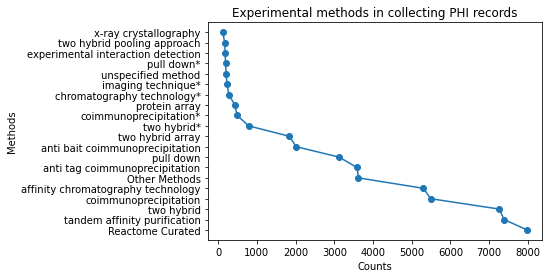

In [9]:
  Method_Counts=phi_data['Experimental Method'].value_counts()[:20]
  plt.plot(Method_Counts.values, Method_Counts.index, marker='o') 
  plt.xlabel('Counts') 
  plt.ylabel('Methods') 
  plt.title('Experimental methods in collecting PHI records') 
  plt.show()


In [ ]:
pathogens=phi_data.drop_duplicates(subset=['Uniprot ID1', 'Uniprot ID2'],keep='first')
print(pathogens['Pathogen'].value_counts()[:30])

Influenza A virus STRAIN A / Wilson-Smith / 1933 (H1N1)                      6062
Influenza A virus STRAIN A / PUERTO RICO / 8 / 1934 (H1N1)                   2570
Human herpesvirus 4 (Epstein-Barr virus) STRAIN AG876                        2123
Human herpesvirus 4 (Epstein-Barr virus) STRAIN B95-8                        2098
Human immunodeficiency virus 1 (HIV1) ISOLATE HXB2                           1891
Human immunodeficiency virus 1 (HIV1)                                         849
Human herpesvirus 1 STRAIN 17                                                 741
Human papillomavirus TYPE 16 (HPV 16)                                         694
Human papillomavirus TYPE 18 (HPV 18)                                         674
Human papillomavirus TYPE 11 (HPV 11)                                         642
Human herpesvirus 8 (Kaposi's sarcoma-associated herpesvirus)                 627
Human immunodeficiency virus 1 (HIV1) ISOLATE BRU                             624
Hepatitis C viru

In [ ]:
def gatherVirusData(prodId):
    try:
        url = "https://www.uniprot.org/uniprot/" + str(prodId) + ".fasta"
        response = urlopen(url)
        fasta = response.read().decode("utf-8", "ignore")
        if fasta:
            dataV[prodId] = fasta
        else:
            print(fasta)
        print(len(dataV))  

    except Exception as ex:
        print("error getting ", prodId, " exception",
              ex) 
        corruptedVirusData.append(prodId)

In [ ]:
def gatherHumanData(prodId):
    try:
        url = "https://www.uniprot.org/uniprot/" + str(prodId) + ".fasta"
        response = urlopen(url)
        fasta = response.read().decode("utf-8", "ignore")
        if fasta:
            dataH[prodId] = fasta
        else:
            print(fasta)
        print(len(dataH))

    except Exception as ex:
        print("error getting ", prodId, " exception", ex)
        corruptedHumanData.append(prodId)

In [ ]:
def runPools(uniqueVirus, uniqueHuman):
    with Pool(5) as maPool:
        maPool.map(gatherVirusData, uniqueVirus)

    with Pool(5) as maOtherPool:
        maOtherPool.map(gatherHumanData, uniqueHuman)

    # print("Virus protein data")
    # print(dataV)
    print("Virus protein sequences length:", (len(dataV)))
    # print("Human protein data")
    # print(dataH)
    print("Human protein sequences length:", (len(dataH)))

    print("Corrupted Human Data Length:", len(corruptedHumanData))
    print("Corrupted Virus Data Length:", len(corruptedVirusData))
    print("Corrupted protein ids are saved to a txt file!")
   
    # Gelmeyenleri kaydettim
    with open("corrHumanData.txt", 'wb') as a:
        pickle.dump(corruptedHumanData, a)

    with open("corrVirusData.txt", 'wb') as b:
        pickle.dump(corruptedVirusData, b)

In [ ]:
def cleaning(dataH, dataV):
    # Boşluk karakterlerini silmek
    for x, y in dataH.items():
        CleanSequenceH[x] = y.replace("\n", '')

    for a, b in dataV.items():
        CleanSequenceV[a] = b.replace("\n", '')

    # SV= ibaresini ile başlayan yerleri seçmek ve SV= ibaresini kaldırmak
    for c, d in CleanSequenceV.items():
        CleanSequenceV[c] = d[d.find('SV='):].replace("SV=", '')
 
    # print(CleanSequenceV)
    # print(len(CleanSequenceV))

    for e, f in CleanSequenceH.items():
        CleanSequenceH[e] = f[f.find('SV='):].replace("SV=", '')

    # Sadece alfabetik karakterler içermesi
    for k, l in CleanSequenceV.items():
        CleanSequenceV[k] = re.sub("[^a-zA-Z]+", "", l)

    for m, n in CleanSequenceH.items():
        CleanSequenceH[m] = re.sub("[^a-zA-Z]+", "", n)

    print("Sequences are cleaned!")
    df_Virus = pd.DataFrame(CleanSequenceV.items(), columns=['VirusProtein', 'VirusSequence'])
    df_Human = pd.DataFrame(CleanSequenceH.items(), columns=['HumanProtein', 'HumanSequence'])

    print("Human proteins with sequences")
    print(df_Human)
    print("Virus proteins with sequences")
    print(df_Virus)
    print("Cleaned sequences are saved with their ids to a csv file")
    df_Virus.to_csv(r'VirusData.csv', index=False)
    df_Human.to_csv(r'HumanData.csv', index=False)


In [ ]:
#runPools(uniqueVirus[:10], uniqueHuman[:10])

In [ ]:
#cleaning(dataH,dataV)

In [ ]:
print("IDs that cannot be scraped from web")

print(myCorruptedHumanData)
print(myCorruptedVirusData)

dataFrameSubPHI = {'HumanProtein': phi_data['Uniprot ID2'].tolist(),
                    'VirusProtein': phi_data['Uniprot ID1'].tolist()}

PHIPositive = pd.DataFrame(dataFrameSubPHI)
print("True Virus-Human Matches with Protein IDs")
print(PHIPositive)
print("Length of it:", len(PHIPositive))

print("Corrupted Proteins of Viruses(All occurences)")
print(PHIPositive.loc[PHIPositive['VirusProtein'].isin(myCorruptedVirusData)])
print("Corrupted Proteins of Humans(All occurences)")
print(PHIPositive.loc[PHIPositive['HumanProtein'].isin(myCorruptedHumanData)])

print("Corrupted virus and human protein ids must be removed from all records")
CorruptedProteinsCleaned1 = PHIPositive[~PHIPositive.VirusProtein.isin(myCorruptedVirusData)]
CorruptedProteinsCleaned2 = CorruptedProteinsCleaned1[
    ~CorruptedProteinsCleaned1.HumanProtein.isin(myCorruptedHumanData)]

print("Cleaning for Virus Proteins")
print(CorruptedProteinsCleaned1)
print("Cleaning for Human Proteins")
print(CorruptedProteinsCleaned2)

CorruptedProteinsCleaned2 = CorruptedProteinsCleaned2.drop_duplicates(subset=['HumanProtein', 'VirusProtein'],
                                                                      keep='first')

print("Dropping duplicates that are because of experimental method differences")
print(CorruptedProteinsCleaned2)


IDs that cannot be scraped from web
['P62158', 'Q96HN2', 'Q13748', 'O43707', 'Q13491', 'A2RUB6', 'O60885', 'P08107', 'Q30KQ2', 'Q04671', 'P62988', 'Q9BZG9', 'Q5W0B1', 'Q9UBM7', 'P0CG06', 'P0CG05', 'A0A024R1Y5', 'Q8TAP4']
['P03076', 'P03074', 'P68320', 'P34015']
True Virus-Human Matches with Protein IDs
      HumanProtein VirusProtein
0           P15311       Q9WIP8
1           P28799       Q6JN72
2           P62937       P88761
3           P62937       P88585
4           P23284       Q77YG1
...            ...          ...
52972       Q92793       P0DOJ6
52973       K7PPA8       P89055
52974       Q8WUM4       Q88019
52975       Q07021       O40955
52976       Q04637       Q3ZK63

[52977 rows x 2 columns]
Length of it: 52977
Corrupted Proteins of Viruses(All occurences)
      HumanProtein VirusProtein
35909       P67775       P03076
35910       B3KUN1       P03076
35994       P27986       P03076
35999       Q92793       P03074
36000       Q09472       P03074
51858       P98179       P68

In [ ]:
print("Joining ids and sequences for the true matches")

joinedDFs1 = pd.merge(CorruptedProteinsCleaned2, myVirusSequences
                      , on='VirusProtein', how='left')
# print(joinedDFs1)

joinedDFs2 = pd.merge(joinedDFs1, myHumanSequences
                      , on='HumanProtein', how='left')

print(joinedDFs2)

print("Infection column is added!")
joinedDFs2['Infection'] = 'True'
print(joinedDFs2)

Joining ids and sequences for the true matches
      HumanProtein VirusProtein  \
0           P15311       Q9WIP8   
1           P28799       Q6JN72   
2           P62937       P88761   
3           P62937       P88585   
4           P23284       Q77YG1   
...            ...          ...   
39497       Q92793       P0DOJ6   
39498       K7PPA8       P89055   
39499       Q8WUM4       Q88019   
39500       Q07021       O40955   
39501       Q04637       Q3ZK63   

                                           VirusSequence  \
0      MGGKWSKSSIIGSPTVRERMKRAEPAADGVGAVSRDLDKYGAITSS...   
1      MEPVDPSLEPWKHPGSQPKTACTNCYCKKCCLHCQVCFMKKGLGIF...   
2      PIVQNLQRQIVHQALSPRTLNAWVKVVEEKAFSPEVIPMFSALSEG...   
3      ELERFAVNPGLLETSEGCRQILGQLQPSLQTGSEELRSLFITVAVL...   
4      MGARASVLSGGELDRWEKIRLRPGGKKKYKLKHIVWASRELERFAV...   
...                                                  ...   
39497  MDRVLSRADKERLLELLKLPRQLWGDFGRMQQAYKQQSLLLHPDKG...   
39498  MATFKDACYHYRKLNKLNGLVLKLGANDAWRPAPIAKYKGWCLDC

In [ ]:
cleanedHumanP = [x for x in uniqueHuman if x not in myCorruptedHumanData]
cleanedVirusP = [y for y in uniqueVirus if y not in myCorruptedVirusData]

print("Cartesian Product of the all known pathogen and host ids")
AllCombinations = pd.DataFrame(list(itertools.product(cleanedHumanP, cleanedVirusP)),
                                columns=['HumanProtein', 'VirusProtein'])
AllCombinations = AllCombinations.drop_duplicates(subset=['HumanProtein', 'VirusProtein'], keep='first')
print(AllCombinations)

print("Labeling records according to where it came from")
FalseMatches = AllCombinations.merge(CorruptedProteinsCleaned2, on=['HumanProtein', 'VirusProtein'], how='left', indicator=True)
print(FalseMatches)

print("False PHI Matches")
print("Dropping if there are duplicate records")
FM = FalseMatches[FalseMatches['_merge'] == 'left_only']
FM = FM.drop_duplicates(subset=['HumanProtein', 'VirusProtein'], keep='first')
print(FM)


Cartesian Product of the all known pathogen and host ids
         HumanProtein VirusProtein
0              P15311       Q9WIP8
1              P15311       Q6JN72
2              P15311       P88761
3              P15311       P88585
4              P15311       Q77YG1
...               ...          ...
11238988       K7PPA8       P0DOJ6
11238989       K7PPA8       P89055
11238990       K7PPA8       Q88019
11238991       K7PPA8       O40955
11238992       K7PPA8       Q3ZK63

[11238993 rows x 2 columns]
Labeling records according to where it came from
         HumanProtein VirusProtein     _merge
0              P15311       Q9WIP8       both
1              P15311       Q6JN72  left_only
2              P15311       P88761  left_only
3              P15311       P88585  left_only
4              P15311       Q77YG1       both
...               ...          ...        ...
11238988       K7PPA8       P0DOJ6  left_only
11238989       K7PPA8       P89055       both
11238990       K7PPA8       Q88

In [ ]:
print("Merging ids in the negative matches with the sequences")

joinedDFs3 = pd.merge(FM, myVirusSequences, on='VirusProtein', how='left')

joinedDFs4 = pd.merge(joinedDFs3, myHumanSequences, on='HumanProtein', how='left')

joinedDFs4['Infection'] = 'False'

joinedDFs4 = joinedDFs4.drop(['_merge'], axis=1)

print(joinedDFs4)

TrueAndFalseMatchesTogether = joinedDFs2.append(joinedDFs4, ignore_index=True)

print("Positive and Negative Matches are added together")
print(TrueAndFalseMatchesTogether)

Merging ids in the false matches with the sequences
         HumanProtein VirusProtein  \
0              P15311       Q6JN72   
1              P15311       P88761   
2              P15311       P88585   
3              P15311       Q77YG0   
4              P15311       B9A2Q4   
...               ...          ...   
11199486       K7PPA8       Q08089   
11199487       K7PPA8       P0DOJ6   
11199488       K7PPA8       Q88019   
11199489       K7PPA8       O40955   
11199490       K7PPA8       Q3ZK63   

                                              VirusSequence  \
0         MEPVDPSLEPWKHPGSQPKTACTNCYCKKCCLHCQVCFMKKGLGIF...   
1         PIVQNLQRQIVHQALSPRTLNAWVKVVEEKAFSPEVIPMFSALSEG...   
2         ELERFAVNPGLLETSEGCRQILGQLQPSLQTGSEELRSLFITVAVL...   
3         MENRWQVMIVWQVDRMRIRTWKSLVKHHMYVSGKARGWFYRHHYES...   
4         MGARASVLSGGELDRWEKIRLRPGGKKKYKLKHIVWASRELERFAV...   
...                                                     ...   
11199486  MVPQALLFVPLLVFPLCFGKFPIYTIPDKLGPWSPIDIHH

In [ ]:
#joinedDFs4.to_csv('HealthyRecords.csv')
#joinedDFs2.to_csv('InfectionRecords.csv')

In [ ]:
shuffled=TrueAndFalseMatchesTogether[:100000]
X = shuffled['VirusSequence'].astype('U').values

print("Vectorization for Virus Sequences")
countVect = CountVectorizer(analyzer='char')

tf1 = countVect.fit_transform(X)
tfidfconverter = TfidfTransformer()
my_tfdf1 = pd.DataFrame(tf1.toarray(), columns=countVect.get_feature_names())

print(my_tfdf1)
tf1 = tfidfconverter.fit_transform(tf1)
my_tfdf1 = pd.DataFrame(tf1.toarray(), columns=countVect.get_feature_names())

#tf_df1.to_csv(r'VirusVector.csv', index=False)

print(my_tfdf1)

Vectorization for Virus Sequences
        a   c   d   e   f   g   h   i   k   l   m   n   p   q   r   s   t   v  \
0      15   4  12  18   7  16   8   7  14  19   7   6  13   7   9  14   7  10   
1       3   7   5   6   2   6   3   1  15   4   2   2  11   8   7   8   5   3   
2      11   0   3   9   2   6   4   5   3   8   4   5   9   8   5   5   5   9   
3       8   2   3  11   2   6   1   6   8  10   2   5   4  14   4   9   7   8   
4      37  10  14  40  11  38  10  26  36  36  16  24  33  34  31  29  31  25   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
99995   6   1   2  10   3   7   4   9   1   9   1   3   4   7  12   4   4   2   
99996   1   7   5   6   1   6   3   1  12   4   1   2  12   9   8   8   8   4   
99997   3   2   5  11   1   9   0   5   3  13   1   5  10   6  16   9   9   5   
99998  17   4  13  19   7  16   9   5  13  17   5   6  15   7  12  10  10  16   
99999  42  21  28  53  25  57  12  67  51  81  18  57  27  43  48  50  59  

In [ ]:
Y = shuffled.Infection
other_X = shuffled['HumanSequence'].astype('U').values

print("Vectorization for Human Sequences")
tf3 = countVect.fit_transform(other_X)
my_tfdf3 = pd.DataFrame(tf3.toarray(), columns=countVect.get_feature_names())
print(my_tfdf3)

tf3 = tfidfconverter.fit_transform(tf3)
my_tfdf3 = pd.DataFrame(tf3.toarray(), columns=countVect.get_feature_names())
print(my_tfdf3)

Vectorization for Human Sequences
        a   c   d   e   f   g   h   i   k   l   m   n   p   q   r   s   t  u  \
0      39   2  34  77  17  20  12  30  55  55  15  20  24  43  47  18  24  0   
1      47  88  36  20  13  47  27   8  16  34   8   9  50  29  33  44  34  0   
2       9   4   7  12  15  23   4  10  14   7   5   9   6   3   6   8  11  0   
3       9   4   7  12  15  23   4  10  14   7   5   9   6   3   6   8  11  0   
4      14   1  15  12  16  25   3  11  26  15   5   6   8   2   9   9  12  0   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  .. ..   
99995  33   1  29  55  10  14   6  15  22  55  10  23   9  33  43  43  25  0   
99996  33   1  29  55  10  14   6  15  22  55  10  23   9  33  43  43  25  0   
99997  33   1  29  55  10  14   6  15  22  55  10  23   9  33  43  43  25  0   
99998  33   1  29  55  10  14   6  15  22  55  10  23   9  33  43  43  25  0   
99999  33   1  29  55  10  14   6  15  22  55  10  23   9  33  43  43  25  0   

     

In [ ]:
print("Vectorization for Labels")
lb = LabelBinarizer()
vector_y = lb.fit_transform(Y)
print(vector_y)

#with open("vector_infection.txt", 'wb') as a:
#  pickle.dump(vector_y, a)

#tf_df3.to_csv(r'HumanVector.csv', index=False)

#shuffled = TrueAndFalseMatchesTogether.sample(frac=1)

Vectorization for Labels
[[1]
 [1]
 [1]
 ...
 [0]
 [0]
 [0]]


In [ ]:
intersection_columns = [value for value in my_tfdf3.columns if value in my_tfdf1.columns]
liste=[]

my_tfdf1.fillna(0)
my_tfdf3.fillna(0)
my_tfdf1.reset_index(drop=True)
my_tfdf3.reset_index(drop=True)

for row in range (len(my_tfdf1['a'])):
  temp_col=[]
  for columnName in intersection_columns:
    value = (my_tfdf1[columnName][row] + my_tfdf3[columnName][row])/2
    temp_col.append(value)
  liste.append(temp_col)

df = pd.DataFrame(liste,columns=intersection_columns)
df['u'] = my_tfdf3['u']
print("Average of Human & Virus Dataframes")
print(df)

#df.to_csv(r'AvgVector.csv', index=False)

#shuffled = TrueAndFalseMatchesTogether.sample(frac=1)

Average of Training
              a         c         d         e         f         g         h  \
0      0.275222  0.048671  0.229827  0.429428  0.127243  0.224041  0.120313   
1      0.199915  0.416103  0.201890  0.170266  0.077644  0.253922  0.139427   
2      0.309206  0.047953  0.137207  0.307789  0.212705  0.378391  0.122848   
3      0.236978  0.083069  0.131068  0.322762  0.208481  0.366129  0.063559   
4      0.270951  0.051931  0.186289  0.267068  0.184400  0.370154  0.067580   
...         ...       ...       ...       ...       ...       ...       ...   
99995  0.246489  0.024550  0.153526  0.412161  0.099791  0.191166  0.103008   
99996  0.148276  0.136260  0.204336  0.325272  0.058142  0.162803  0.078653   
99997  0.176369  0.036485  0.191582  0.387025  0.055510  0.193606  0.023862   
99998  0.291080  0.044067  0.238059  0.398181  0.108207  0.207010  0.110859   
99999  0.231113  0.057331  0.182089  0.345334  0.101762  0.192412  0.053288   

              i         k      

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, vector_y, test_size=0.2, random_state=1)
classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


[[11677   298]
 [  911  7114]]
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     11975
           1       0.96      0.89      0.92      8025

    accuracy                           0.94     20000
   macro avg       0.94      0.93      0.94     20000
weighted avg       0.94      0.94      0.94     20000

0.93955


In [ ]:
classifier = SVC(kernel='rbf', random_state = 1)
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[11105   870]
 [ 2019  6006]]
              precision    recall  f1-score   support

           0       0.85      0.93      0.88     11975
           1       0.87      0.75      0.81      8025

    accuracy                           0.86     20000
   macro avg       0.86      0.84      0.85     20000
weighted avg       0.86      0.86      0.85     20000

0.85555


In [ ]:
model = MultinomialNB()
model.fit(X_train,y_train)
y_pred= model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

[[11975     0]
 [ 8022     3]]
              precision    recall  f1-score   support

           0       0.60      1.00      0.75     11975
           1       1.00      0.00      0.00      8025

    accuracy                           0.60     20000
   macro avg       0.80      0.50      0.37     20000
weighted avg       0.76      0.60      0.45     20000

0.5989


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
